# Stance Detection Using Bidirectional Long Short-Term Memory

`Bidirectional Long Short-Term Memory`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on a very simple bidirectional long short-term memory to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [2]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [4]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [5]:
instance_no = 50
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: انتشار فيروس كورونا في مستشفيات جدة
Article text: دبي، الإمارات العربية المتحدة()-- مع الطوارئ التي تعيشها وزارات الصحة والمنظمات الدولية في مختلف أنحاء العالم لكشف سرّ فيروس "كورونا" تجري بهدوء وبعيدا عن أعين الناس، معركة من نوع آخر رهانها الملكية الفكرية لهذا الفيروس المخيف. في يونيو/حزيران 2012، كان البروفيسور المصري علي محمد زكي يعمل في مستشفى الدكتور سليمان الفقيه في جدة، ونجح في عزل فيروس من رجل توفي في أعقاب ضيق حاد في التنفس وفشل كلوي. وعجز البروفيسور عن تحديد سبب الوفاة واتصل بالسلطات محاولا إقناعها بضرورة التنبه وعدم ترك الأمر، ولكنه أيضا اتصل بعالم جراثيم معروف هو الدكتور رون فيوشيه الذي يشرف على مختبر علمي في هولندا الذي اشتهر في العالم باكتشافه الفيروس الآخر: 15 من أنفلونزا الطيور. أكّد فوشيه لزكي أنّ الأمر يتعلق بسلالة قديمة غير معروفة من فيروس "كورونا"، انحدرت على ما يبدو من الخفافيش، قائلا إنّ العينة كانت إيجابية المصل. وفي 20 سبتمبر/أيلول، نشر زكي ما خلص إليه على الشبكة الأوروبية -، ومن ساعتها تم اختيار اسم أكثر تعقيدا للفيروس. وباتت هيئات بحث ودول ومؤسسات 

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [6]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [7]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [8]:
instance_no = 50
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: انتشار فيروس كورونا في مستشفيات جده دبي الامارات العربيه المتحده مع الطوارئ التي تعيشها وزارات الصحه والمنظمات الدوليه في مختلف انحاء العالم لكشف سر فيروس كورونا تجري بهدوء وبعيدا عن اعين الناس معركه من نوع اخر رهانها الملكيه الفكريه لهذا الفيروس المخيف في يونيو حزيران الفان و اثنا عشر كان البروفيسور المصري علي محمد زكي يعمل في مستشفي الدكتور سليمان الفقيه في جده ونجح في عزل فيروس من رجل توفي في اعقاب ضيق حاد في التنفس وفشل كلوي وعجز البروفيسور عن تحديد سبب الوفاه واتصل بالسلطات محاولا اقناعها بضروره التنبه وعدم ترك الامر ولكنه ايضا اتصل بعالم جراثيم معروف هو الدكتور رون فيوشيه الذي يشرف علي مختبر علمي في هولندا الذي اشتهر في العالم باكتشافه الفيروس الاخر خمس عشره من انفلونزا الطيور اكد فوشيه لزكي ان الامر يتعلق بسلاله قديمه غير معروفه من فيروس كورونا انحدرت علي ما يبدو من الخفافيش قائلا ان العينه كانت ايجابيه المصل وفي عشرون سبتمبر ايلول نشر زكي ما خلص اليه علي الشبكه الاوروبيه ومن ساعتها تم اختيار اسم اكثر تعقيدا للفيروس وباتت هيئات بحث ودول ومؤسسات ومختبرات تطلب 

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [10]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [11]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=100, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [12]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19860 words (140 misses)


- Let's see the representation of a random token:

In [13]:
print(f"The word 'اليوم' is at index {word_index['مرحبا']}")
print(f"The vector representation of 'اليوم' is {embedding_matrix[word_index['اليوم']]}")

The word 'اليوم' is at index 16121
The vector representation of 'اليوم' is [-1.97517073e+00  8.69537115e-01  8.18713903e-01 -3.29231572e+00
 -1.19689381e+00 -3.43032455e+00 -1.21804047e+00 -1.95108867e+00
  2.29376483e+00 -1.43319929e+00 -1.77860498e+00 -1.04377866e+00
  4.38264513e+00  2.09589195e+00  1.68843174e+00  9.52437460e-01
  4.59254950e-01  4.75610346e-01 -2.27967167e+00  1.36259210e+00
  5.34933567e-01 -8.24885488e-01 -2.58660447e-02  1.12652564e+00
 -1.50918436e+00 -3.49571258e-01  6.60924792e-01  9.72745474e-03
 -4.91223186e-01  8.95809948e-01 -1.03281677e+00 -2.15446100e-01
  1.77518234e-01 -1.41457045e+00  1.23311186e+00  1.09764107e-01
 -7.40322828e-01  3.91151518e-01 -5.51507413e-01  1.28212833e+00
 -1.13139379e+00 -1.10803485e+00  1.08339655e+00  2.48234773e+00
 -2.63052058e+00  2.20979428e+00  4.04768705e-01 -3.78537893e+00
  2.75179935e+00  8.10063124e-01  2.48981667e+00 -7.77087927e-01
 -3.93588126e-01 -1.64708638e+00 -8.15965652e-01 -1.29414165e+00
  3.33083779e-0

- Let's initialize our embedding layer with the embedding matrix:

In [14]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [15]:
batch_size = 64

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [16]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [17]:
instance_no = 50
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: انتشار فيروس كورونا في مستشفيات جده دبي الامارات العربيه المتحده مع الطوارئ التي تعيشها وزارات الصحه والمنظمات الدوليه في مختلف انحاء العالم لكشف سر فيروس كورونا تجري بهدوء وبعيدا عن اعين الناس معركه من نوع اخر رهانها الملكيه الفكريه لهذا الفيروس المخيف في يونيو حزيران الفان و اثنا عشر كان البروفيسور المصري علي محمد زكي يعمل في مستشفي الدكتور سليمان الفقيه في جده ونجح في عزل فيروس من رجل توفي في اعقاب ضيق حاد في التنفس وفشل كلوي وعجز البروفيسور عن تحديد سبب الوفاه واتصل بالسلطات محاولا اقناعها بضروره التنبه وعدم ترك الامر ولكنه ايضا اتصل بعالم جراثيم معروف هو الدكتور رون فيوشيه الذي يشرف علي مختبر علمي في هولندا الذي اشتهر في العالم باكتشافه الفيروس الاخر خمس عشره من انفلونزا الطيور اكد فوشيه لزكي ان الامر يتعلق بسلاله قديمه غير معروفه من فيروس كورونا انحدرت علي ما يبدو من الخفافيش قائلا ان العينه كانت ايجابيه المصل وفي عشرون سبتمبر ايلول نشر زكي ما خلص اليه علي الشبكه الاوروبيه ومن ساعتها تم اختيار اسم اكثر تعقيدا للفيروس وباتت هيئات بحث ودول ومؤسسات وم

- Let's initialize the datasets we are going to use for the training and testing:

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [19]:
lr = 1e-4
epochs = 100
drop_rate = 0.4

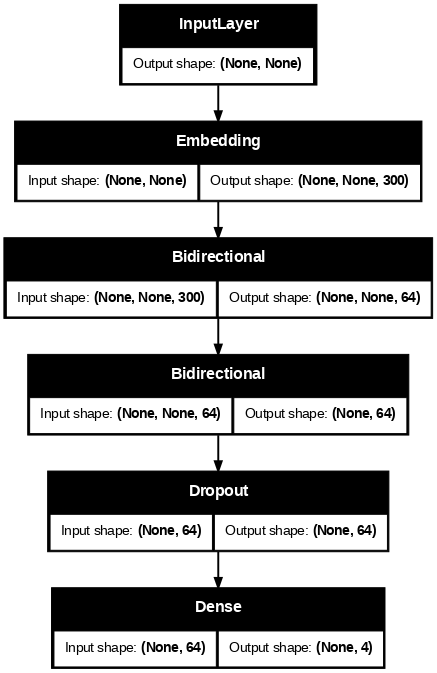

In [20]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

lstm_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
lstm_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_output_1)

dropped = tf.keras.layers.Dropout(drop_rate)(lstm_output_2)

logits = tf.keras.layers.Dense(4)(dropped)

model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 300)           │       6,000,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 64)            │          85,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,110,940 (23.31 MB)

 Trainable params: 110,340 (431.02 KB)

 Non-trainable params: 6,000,600 (22.89 MB)

## Training

In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [23]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
history=model.fit(
  x=train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.2936 - loss: 1.3705 - val_accuracy: 0.4868 - val_loss: 1.2779
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5119 - loss: 1.2031 - val_accuracy: 0.5149 - val_loss: 1.2169
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5557 - loss: 1.1249 - val_accuracy: 0.5185 - val_loss: 1.2027
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5575 - loss: 1.0917 - val_accuracy: 0.5237 - val_loss: 1.1911
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5653 - loss: 1.0655 - val_accuracy: 0.5272 - val_loss: 1.1784
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5933 - loss: 1.0238 - val_accuracy: 0.5325 - val_loss: 1.1631
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6218 - loss: 0.9780 - val_accuracy: 0.5395 - val_loss: 1.1474
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6269 - loss: 0.9365 - val_accuracy: 0.

- Plot learning curves:

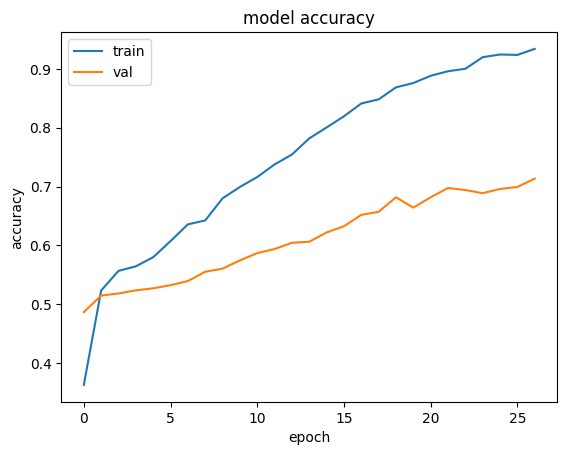

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

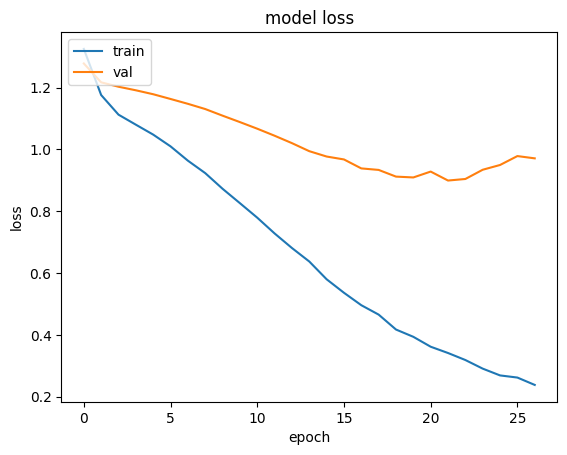

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

- Despite the continuous improvement on the validation dataset, the model is clearly overfitting the training data.

## Evaluation

In [26]:
loss, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7114 - loss: 0.9891
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Loss                       : 0.9709908962249756
Accuracy                   : 0.7135325131810193
F1 score                   : [0.65236052 0.57142857 0.37623762 0.81371088]
Macro F1 score             : 0.6034343973742642


In [27]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7737 - loss: 0.6856
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Loss                       : 0.8015652298927307
Accuracy                   : 0.7554179566563467
F1 score                   : [0.72483221 0.54054054 0.18181818 0.86037736]
Macro F1 score             : 0.5768920739035973


- Let's see the confusion matrix on the testing dataset:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


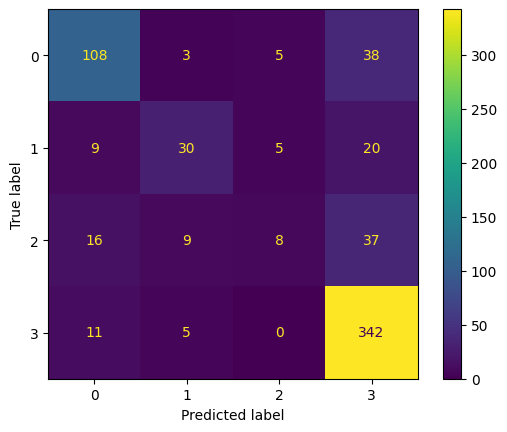

In [28]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

- The model is misclassifying too many instances from the relatively easy 'unrelated' class.
- Despite that, most of the misclassifications are on instances from the 'agree', 'disagree', and 'discuss' classes.
- What is realy interesting is the number of instances from the 'discuss' class, the model is misclassifying as 'agree' instances.

## A Word on overfitting

- In [A Word on Overfitting](https://github.com/Ali-Mhrez/Stance-Detection/blob/main/SD_MLP.ipynb), we argue that the performance on the validation set stopped improving due to limits in the dataset, thus it is not clear how much we should attribute the learning curves to the overfitting versus model struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes.